# Tweeter Bot Classifer

## Integrating machine learning to detect bots

Over the past ten plus years, Twitter has explosively evolved into a major communication hub. "Its primary purpose is to connect people and allow people to share their thoughts with a big audience. Twitter can also be a very helpful platform for growing a following and providing your audience with valuable content before they even become customers" [Hubspot](https://blog.hubspot.com/marketing/what-is-twitter). However, not all accounts are geninue users. According to a Twitter SEC filling in 2017, Twitter estimated 8.5% of all users to be bots. To validate the credibility of communication exchanged on the platform, efforts in idnetifying spam bots will help improve user's experience on twitter. 

In this project, we will be using [The Fake Project](https://botometer.iuni.iu.edu/bot-repository/datasets.html) collected by S. Cresci, R. Di Pietro, M. Petrocchi, A. Spognardi, M. Tesconi in 2017. 

We'll begin with exploring traits between geniuine and bot accounts. Then, we will create supervised learning models (Logistic Regression, Random Forest, Nueral Networks) to create a Twitter bot classifer. Finally, we'll use clustering to identify certain specific behavioral groups of accounts. 

 
### Overview of Data
We'll be using 4 data tables from the Fake Project: 
 * __genuine accounts__: randomly sampled human-operated accounts verfied through responses of questions in natural language (2011)
 * __social spambots #1__: retweeters of an Italian political candiate (2012)
 * __social spambots #2__: spammers of #TALNTS (paid apps) for mobile devices (2014)
 * __social spambots #3__: spammers of products(URLs) on sale at Amazon.com (2011)
 

Each dataset contains two tables: tweets and users. Below are some highlighted features. 

__Tweets Table__

- id: text id
- text: content of tweet
- source: tweet source
- user_id: id of account user
- in_reply_to_status_id: 
- in_reply_to_user_id:
- retweeted_status_id:
- retweet_count:
- reply_count:
- favorite_count: 
- num_hashtags: acount of hastags in tweet
- num_urls: 
- num_mentions: 
- created_at
- timestamp
- crawled_at
- updated

__Users Table__

- id: user id
- name: user name
- screen_name: 
- statuses_count:
- followers_count: 
- favourites_count:
- listed_count:
- lang:
- profile varaiables include image url, color, fill etc. 
- created_at
- timestamp
- crawled_at
- updated


We will concatenate all tweeets tables to form an aggreated tweets table. The same method will be applied for users tables. For more information regarding the collection of data: [The Paradigm-Shift of Social Spambots:
Evidence, Theories, and Tools for the Arms Race](http://papers.www2017.com.au.s3-website-ap-southeast-2.amazonaws.com/companion/p963.pdf)


In [1]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistics tools
import scipy.stats as stats

# Sklearn data clean
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Datetime
from datetime import datetime

# Import data
import warnings

Let's start by importing tweets and users datasets. 

In [2]:
# Import genuine accounts 
g_tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/genuine_accounts.csv/tweets.csv')

# Import spam bot accounts
soc_bot1_tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_1.csv/tweets.csv')
soc_bot2_tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_2.csv/tweets.csv')
soc_bot3_tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_3.csv/tweets.csv')


/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print('Genuine tweets')
print(g_tweets.shape)

print('---------------')

print('Spam bot tweets')
print(soc_bot1_tweets.shape)
print(soc_bot2_tweets.shape)
print(soc_bot3_tweets.shape)

Genuine tweets
(2839362, 25)
---------------
Spam bot tweets
(1610034, 25)
(428542, 25)
(1418557, 25)


In [4]:
# Import genuine accounts 
g_users = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/genuine_accounts.csv/users.csv')

# Import spam bot accounts
soc_bot1_users = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_1.csv/users.csv')
soc_bot2_users = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_2.csv/users.csv')
soc_bot3_users = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_3.csv/users.csv')


In [5]:
print('Genuine users')
print(g_users.shape)

print('---------------')

print('Spam bot users')
print(soc_bot1_users.shape)
print(soc_bot2_users.shape)
print(soc_bot3_users.shape)

Genuine users
(3474, 42)
---------------
Spam bot users
(991, 41)
(3457, 40)
(464, 41)


## Merging datasets
To create a dataset for modeling, we will aggregate all Tweets table together to form one Tweets. A class column will be added to indicate the original source table. Accounts from the Spambots table will be represented by '1' while '0' for genuine accounts. The following method will also be applied to all Users tables. 


In [6]:
# Join social bots
b_tweets = pd.concat([soc_bot1_tweets,soc_bot2_tweets,soc_bot3_tweets], ignore_index=True, sort=False)

In [7]:
# Create tweet class, 1 for bot and 0 for genuine tweets
b_tweets['class'] = 1
g_tweets['class'] = 0

In [8]:
# Concatenate df
tweets = pd.concat([b_tweets,g_tweets], ignore_index=True, sort=False)

# Randomly shuffle df 
tweets = tweets.reindex(np.random.permutation(tweets.index))

In [9]:
tweets.shape

(6296495, 26)

In [10]:
tweets.head()

,id,text,source,user_id,truncated,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,retweeted_status_id,geo,...,retweeted,possibly_sensitive,num_hashtags,num_urls,num_mentions,created_at,timestamp,crawled_at,updated,class
579570,528273451556298752,http://t.co/EQFRnAUDVs,"<a href=""http://www.fulviocoloretwit.com"" rel=...",4.664498e+08,NaN,0.0,0.0,NaN,0.000000e+00,NaN,...,NaN,NaN,0.0,1.0,0.0,Fri Oct 31 19:53:00 +0000 2014,2014-10-31 20:53:00,2014-11-13 08:11:44,2014-11-13 08:11:44,1
5819477,589861464631980032,RT @GirIyTattoos: http://t.co/hFXu9Yz6RV,"<a href=""http://twitter.com/download/android"" ...",2.290984e+09,NaN,0.0,0.0,NaN,5.667312e+17,NaN,...,NaN,NaN,0.0,0.0,1.0,Sun Apr 19 18:41:46 +0000 2015,2015-04-19 20:41:46,2015-05-01 15:55:25,2015-05-01 15:55:25,0
1194954,372197626466557952,"""Soltanto alla fine della conoscenza di tutte ...","<a href=""http://tweetadder.com"" rel=""nofollow""...",5.757165e+08,NaN,0.0,0.0,NaN,0.000000e+00,NaN,...,NaN,NaN,0.0,0.0,0.0,Tue Aug 27 03:23:23 +0000 2013,2013-08-27 05:23:23,2014-11-13 13:21:01,2014-11-13 13:21:01,1
2482922,520101615509200896,The designated hitter rule is like letting som...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",3.262368e+08,NaN,0.0,0.0,NaN,0.000000e+00,NaN,...,NaN,NaN,0.0,0.0,0.0,Thu Oct 09 06:41:02 +0000 2014,2014-10-09 08:41:02,2014-11-13 01:02:23,2014-11-13 01:02:23,1
1117060,490933527677243393,I medici scrivono male così i pazienti non cap...,"<a href=""http://www.NonSoloGossip.it"" rel=""nof...",5.642496e+08,NaN,0.0,0.0,NaN,0.000000e+00,NaN,...,NaN,NaN,0.0,0.0,0.0,Sun Jul 20 18:57:28 +0000 2014,2014-07-20 20:57:28,2014-11-13 12:47:31,2014-11-13 12:47:31,1


In [11]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6296495 entries, 579570 to 4934133
Data columns (total 26 columns):
id                         object
text                       object
source                     object
user_id                    float64
truncated                  float64
in_reply_to_status_id      float64
in_reply_to_user_id        float64
in_reply_to_screen_name    object
retweeted_status_id        float64
geo                        float64
place                      object
contributors               float64
retweet_count              float64
reply_count                float64
favorite_count             float64
favorited                  float64
retweeted                  float64
possibly_sensitive         float64
num_hashtags               float64
num_urls                   float64
num_mentions               float64
created_at                 object
timestamp                  object
crawled_at                 object
updated                    object
class           

Currently, the Tweets table consists of 6,296,495 million tweets and 26 features holding information such as the user's tweet message, source, and post time. 


Now, let's do the same for the users datasets. First, we will drop test columns in g_users, soc_bot1_users and soc_bot3_users so that we can have even numbers of columns. 

In [12]:
g_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3474 entries, 0 to 3473
Data columns (total 42 columns):
id                                    3474 non-null int64
name                                  3473 non-null object
screen_name                           3474 non-null object
statuses_count                        3474 non-null int64
followers_count                       3474 non-null int64
friends_count                         3474 non-null int64
favourites_count                      3474 non-null int64
listed_count                          3474 non-null int64
url                                   1266 non-null object
lang                                  3474 non-null object
time_zone                             2475 non-null object
location                              2365 non-null object
default_profile                       1032 non-null float64
default_profile_image                 13 non-null float64
geo_enabled                           2155 non-null float64
profile_image

In [13]:
soc_bot1_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 41 columns):
id                                    991 non-null int64
name                                  991 non-null object
screen_name                           991 non-null object
statuses_count                        991 non-null int64
followers_count                       991 non-null int64
friends_count                         991 non-null int64
favourites_count                      991 non-null int64
listed_count                          991 non-null int64
url                                   22 non-null object
lang                                  991 non-null object
time_zone                             903 non-null object
location                              745 non-null object
default_profile                       145 non-null float64
default_profile_image                 1 non-null float64
geo_enabled                           18 non-null float64
profile_image_url               

In [14]:
soc_bot2_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457 entries, 0 to 3456
Data columns (total 40 columns):
id                                    3457 non-null int64
name                                  3457 non-null object
screen_name                           3457 non-null object
statuses_count                        3457 non-null int64
followers_count                       3457 non-null int64
friends_count                         3457 non-null int64
favourites_count                      3457 non-null int64
listed_count                          3457 non-null int64
url                                   10 non-null object
lang                                  3457 non-null object
time_zone                             14 non-null object
location                              13 non-null object
default_profile                       15 non-null float64
default_profile_image                 46 non-null float64
geo_enabled                           5 non-null float64
profile_image_url       

In [15]:
soc_bot3_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464 entries, 0 to 463
Data columns (total 41 columns):
id                                    464 non-null int64
name                                  464 non-null object
screen_name                           464 non-null object
statuses_count                        464 non-null int64
followers_count                       464 non-null int64
friends_count                         464 non-null int64
favourites_count                      464 non-null int64
listed_count                          464 non-null int64
url                                   253 non-null object
lang                                  464 non-null object
time_zone                             303 non-null object
location                              54 non-null object
default_profile                       178 non-null float64
default_profile_image                 0 non-null float64
geo_enabled                           10 non-null float64
profile_image_url               

In [16]:
# Select common columns 
g_users.drop(['test_set_1','test_set_2'], axis=1, inplace=True)

soc_bot1_users.drop('test_set_1', axis=1, inplace=True)
soc_bot3_users.drop('test_set_2', axis=1, inplace=True)

In [17]:
b_users = pd.concat([soc_bot1_users,soc_bot2_users,soc_bot3_users], ignore_index=True, sort=False)

In [18]:
# Create tweet class, 1 for bot and 0 for genuine tweets
b_users['class'] = 1
g_users['class'] = 0

In [19]:
# Concatenate df
users = pd.concat([b_users,g_users], ignore_index=True, sort=False)

# Randomly shuffle df 
users = users.reindex(np.random.permutation(users.index))

In [20]:
users.shape

(8386, 41)

In [21]:
users.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,lang,...,verified,notifications,description,contributors_enabled,following,created_at,timestamp,crawled_at,updated,class
2966,2350533637,Johnette Papps,JohnettePapps,74,4,44,0,0,NaN,en,...,NaN,NaN,NaN,NaN,NaN,Tue Feb 18 18:47:42 +0000 2014,2014-02-18 19:47:42,2014-05-05 00:21:24,2016-03-15 15:12:45,1
8234,1559643193,Triston Rich,triston_rich,404,139,172,365,0,NaN,en,...,NaN,NaN,NaN,NaN,NaN,Mon Jul 01 04:23:39 +0000 2013,2013-07-01 06:23:39,2015-05-02 08:37:23,2016-03-15 16:10:36,0
1287,2352962360,Grazyna Kenan,GrazynaKenan,78,5,34,0,1,NaN,en,...,NaN,NaN,NaN,NaN,NaN,Thu Feb 20 09:03:35 +0000 2014,2014-02-20 10:03:35,2014-05-05 00:21:22,2016-03-15 15:03:43,1
4014,2384835313,Huong Borella,HuongBorella,42,2,36,0,0,NaN,en,...,NaN,NaN,NaN,NaN,NaN,Wed Mar 12 07:07:23 +0000 2014,2014-03-12 08:07:23,2014-05-04 00:22:13,2016-03-15 15:18:24,1
2387,2354580744,Jimmie Valli,JimmieValli,63,5,37,0,0,NaN,en,...,NaN,NaN,NaN,NaN,NaN,Fri Feb 21 10:19:20 +0000 2014,2014-02-21 11:19:20,2014-05-05 00:20:56,2016-03-15 15:09:37,1


In [22]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8386 entries, 2966 to 3092
Data columns (total 41 columns):
id                                    8386 non-null int64
name                                  8385 non-null object
screen_name                           8386 non-null object
statuses_count                        8386 non-null int64
followers_count                       8386 non-null int64
friends_count                         8386 non-null int64
favourites_count                      8386 non-null int64
listed_count                          8386 non-null int64
url                                   1551 non-null object
lang                                  8386 non-null object
time_zone                             3695 non-null object
location                              3177 non-null object
default_profile                       1370 non-null float64
default_profile_image                 60 non-null float64
geo_enabled                           2188 non-null float64
profile_im

The Users table contains 8,386 accounts and 41 columns regarding the user's profile, activities, and interaction with other accounts. 

## Missing Values
Now, we will take a look at missing values in each column.

In [23]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [24]:
missing_values_table(tweets)

Your selected dataframe has 26 columns.
There are 24 columns that have missing values.


,Missing Values,% of Total Values
truncated,6296495,100.0
geo,6296495,100.0
contributors,6296495,100.0
favorited,6296495,100.0
retweeted,6296495,100.0
possibly_sensitive,6270292,99.6
place,6169527,98.0
in_reply_to_screen_name,5295806,84.1
text,12987,0.2
source,73,0.0


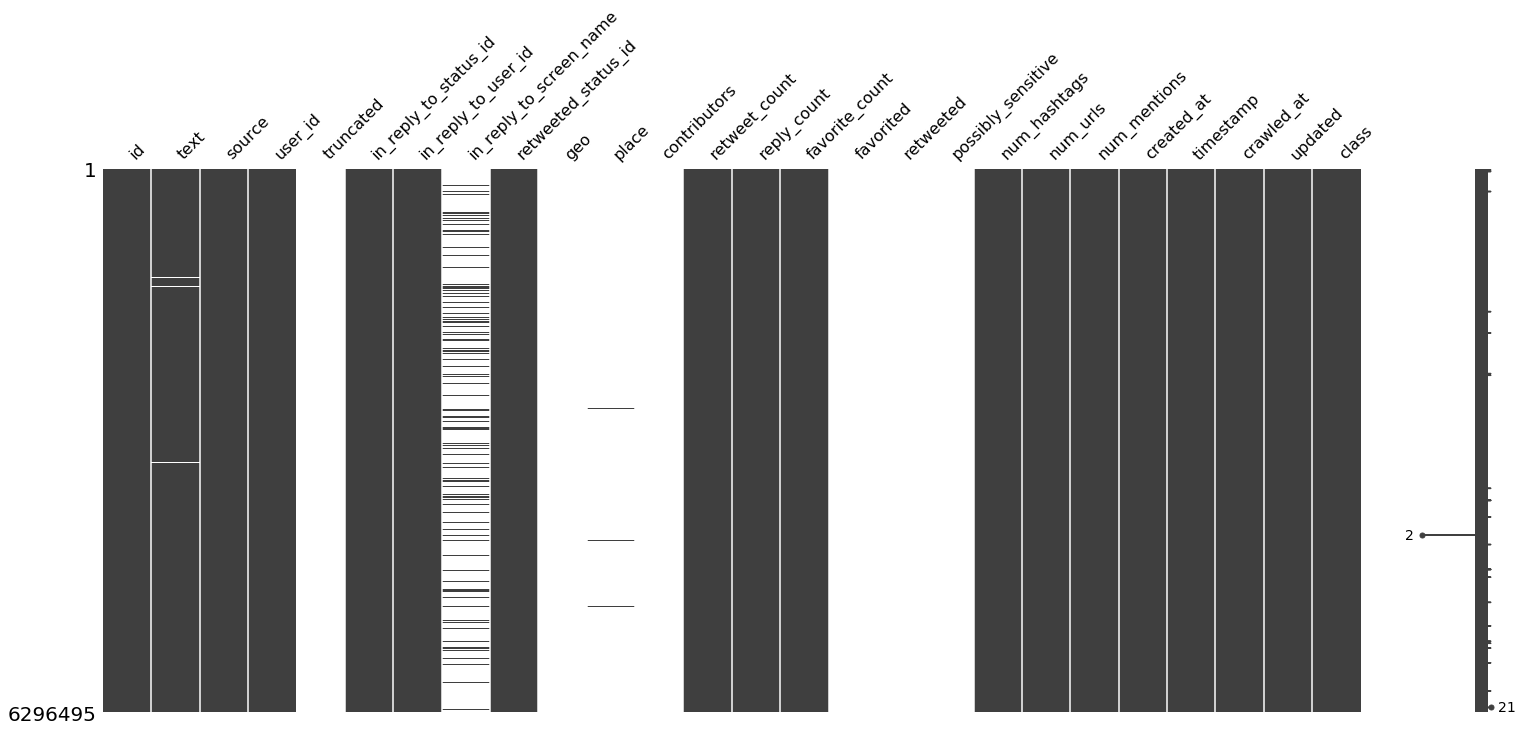

In [25]:
msno.matrix(tweets)

As shown in the matrix, many columns such as truncated, geo, contributors, etc. appear to be missing all datapoints. The data doesn't appear to be missing at random since there is a repetitive pattern between those columns. 

We will drop columns missing more than 90% of data points and in_reply_to_screen_name since that isn't our focus. Then, we will drop the remaining rows with missing values since that is only a small percentage of the dataset.

In [26]:
# Get columns with >= 80% missing
missing_df = missing_values_table(tweets)
missing_columns = list(missing_df[missing_df['% of Total Values'] >= 80].index)
print('We will drop %d columns.' % len(missing_columns))
print('Drop columns: ', missing_columns)

Your selected dataframe has 26 columns.
There are 24 columns that have missing values.
We will drop 8 columns.
Drop columns:  ['truncated', 'geo', 'contributors', 'favorited', 'retweeted', 'possibly_sensitive', 'place', 'in_reply_to_screen_name']


In [27]:
# Drop columns with more than 80% missing values
tweets.drop(labels=['truncated', 'geo', 'contributors', 'favorited', 'retweeted', 'possibly_sensitive', 'place','in_reply_to_screen_name'], axis=1, inplace=True)

In [28]:
# Drop all rows that have any NaN values
tweets = tweets.dropna()
tweets = tweets.reset_index(drop=True)

In [29]:
missing_values_table(tweets)

Your selected dataframe has 18 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Next, we'll take a look at the users table. 

In [30]:
missing_values_table(users)

Your selected dataframe has 41 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
following,8386,100.0
contributors_enabled,8386,100.0
follow_request_sent,8386,100.0
notifications,8386,100.0
is_translator,8385,100.0
verified,8375,99.9
default_profile_image,8326,99.3
protected,8308,99.1
default_profile,7016,83.7
url,6835,81.5


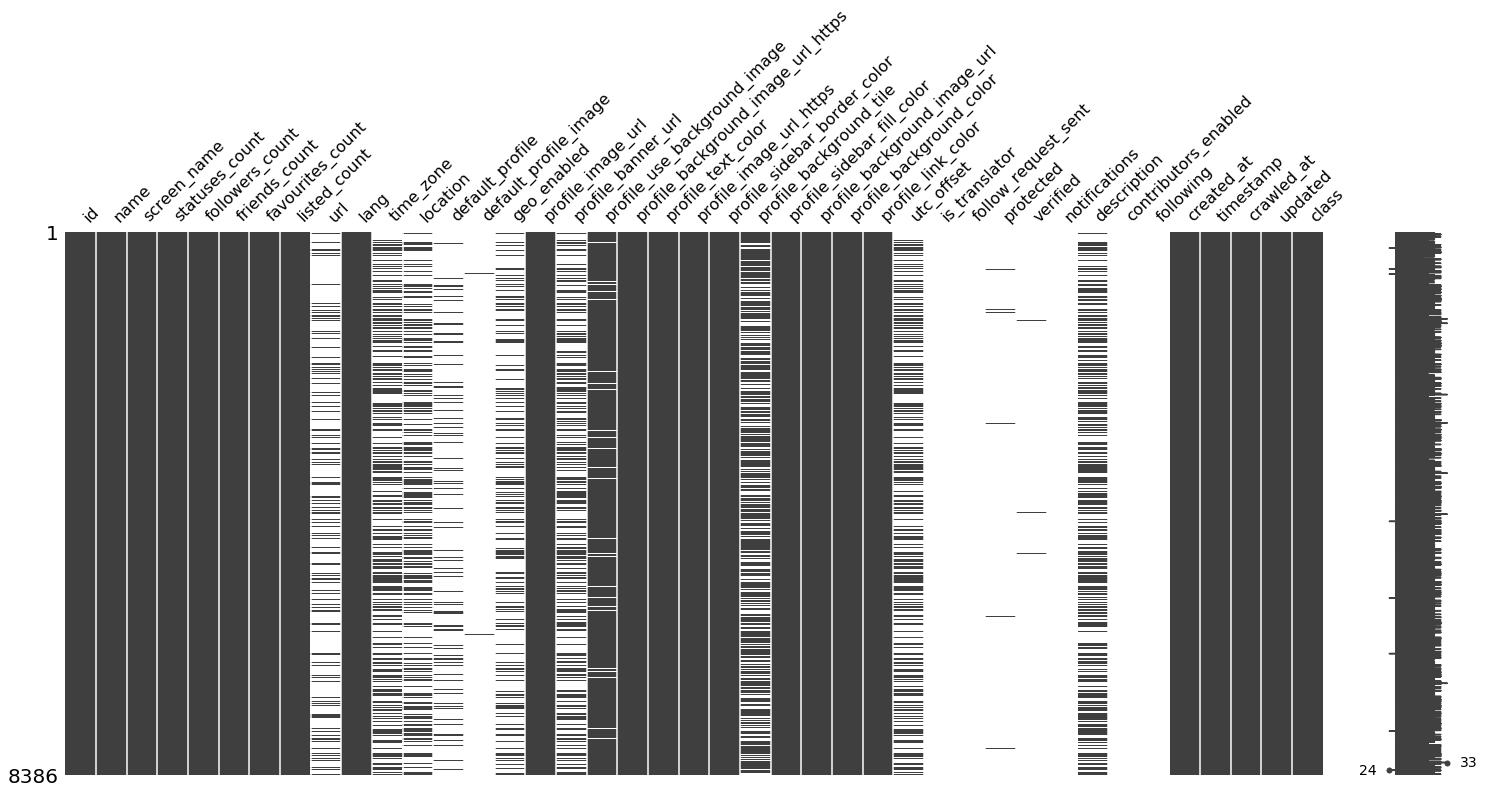

In [31]:
msno.matrix(users)

Similar to the Tweets table, several columns such as following, contributers_enabled, and follow_request_sent appear to be almost or completely missing. Other columns, like time_zone and utc_offset, appear to be missing data at the same indices, indicating a dependency between those features. 

Due to the type of the dataset, we are unable to provide an estimate for the missing values. Columns with more than 30% missing data will be dropped. Then, rows with nulls will also be dropped. 


In [32]:
# Get columns with >= 30% missing
missing_df = missing_values_table(users)
missing_columns = list(missing_df[missing_df['% of Total Values'] >= 30].index)
print('We will drop %d columns.' % len(missing_columns))
print('Drop columns: ', missing_columns)

Your selected dataframe has 41 columns.
There are 19 columns that have missing values.
We will drop 17 columns.
Drop columns:  ['following', 'contributors_enabled', 'follow_request_sent', 'notifications', 'is_translator', 'verified', 'default_profile_image', 'protected', 'default_profile', 'url', 'geo_enabled', 'location', 'profile_banner_url', 'time_zone', 'utc_offset', 'description', 'profile_background_tile']


In [33]:
# Drop columns with more than 30% missing values
users.drop(labels=['following', 'contributors_enabled', 'follow_request_sent', 'notifications', 'is_translator', 'verified', 'default_profile_image', 'protected', 'default_profile', 'url', 'geo_enabled', 'location', 'profile_banner_url', 'time_zone', 'utc_offset', 'description', 'profile_background_tile'], axis=1, inplace=True)

In [34]:
# Drop all rows that have any NaN values
users = users.dropna()
users = users.reset_index(drop=True)

In [35]:
missing_values_table(users)

Your selected dataframe has 24 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Reassigning data types 

In [36]:
cols = ['user_id','in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweet_count','reply_count','favorite_count','num_hashtags','num_urls','num_mentions']
tweets[cols] = tweets[cols].astype('int64')

In [37]:
users['profile_use_background_image'] = users['profile_use_background_image'].astype('int64')

### Examine 'user_id' in Tweets table
Before we continue, let's confirm whether user ids in the Tweets table are unique to each account. First, we'll partition the dataset by class and then merge on _user_id_ to see if there is overlap. 


In [38]:
# Create df for user class
bots = tweets.loc[tweets['class']==1]
gen = tweets.loc[tweets['class']==0]

In [39]:
bots = pd.DataFrame(bots)
gen = pd.DataFrame(gen)

In [40]:
merge = bots.merge(gen, on='user_id')

In [41]:
print(merge)

Empty DataFrame
Columns: [id_x, text_x, source_x, user_id, in_reply_to_status_id_x, in_reply_to_user_id_x, retweeted_status_id_x, retweet_count_x, reply_count_x, favorite_count_x, num_hashtags_x, num_urls_x, num_mentions_x, created_at_x, timestamp_x, crawled_at_x, updated_x, class_x, id_y, text_y, source_y, in_reply_to_status_id_y, in_reply_to_user_id_y, retweeted_status_id_y, retweet_count_y, reply_count_y, favorite_count_y, num_hashtags_y, num_urls_y, num_mentions_y, created_at_y, timestamp_y, crawled_at_y, updated_y, class_y]
Index: []

[0 rows x 35 columns]


Looks like each _user_id_ is specific to each class. We'll also check if the unique amount of _user_id_ for each class adds up to the total _user_id_ of the dataset. 

In [42]:
# Total user_id count 
len(tweets['user_id'].unique().tolist())

5995

In [43]:
# Number of unique user accounts
len(bots['user_id'].unique().tolist())

4912

In [44]:
# Number of unique user accounts
len(gen['user_id'].unique().tolist())

1083

In [45]:
print((len(bots['user_id'].unique().tolist())+(len(gen['user_id'].unique().tolist()))))

5995


Here, we can see there are 4,912 bot users and 1083 human users that make make up 5,995 total unique accounts. 

### Creating Time Series 

Time series data is used when we want to analyze or explore variation over time. This is useful when exploring Twitter text data if we want to track the prevalence of a word or set of words.

Let's convert timestamp into time datatype. 

In [46]:
# Print created_at to see the original format of datetime in Twitter data
print(tweets['created_at'].head())

0    Fri Oct 31 19:53:00 +0000 2014
1    Sun Apr 19 18:41:46 +0000 2015
2    Tue Aug 27 03:23:23 +0000 2013
3    Thu Oct 09 06:41:02 +0000 2014
4    Sun Jul 20 18:57:28 +0000 2014
Name: created_at, dtype: object


In [47]:
# Convert the time columns to np.datetime object
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])

In [48]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

In [49]:
tweets['crawled_at'] = pd.to_datetime(tweets['crawled_at'])

In [50]:
tweets['updated'] = pd.to_datetime(tweets['updated'])

In [51]:
# Print created_at to see new format
print(tweets['created_at'].head())

0   2014-10-31 19:53:00+00:00
1   2015-04-19 18:41:46+00:00
2   2013-08-27 03:23:23+00:00
3   2014-10-09 06:41:02+00:00
4   2014-07-20 18:57:28+00:00
Name: created_at, dtype: datetime64[ns, UTC]


Now, let's do the same for the users table.

In [52]:
# Convert the created_at column to np.datetime object
users['timestamp'] = pd.to_datetime(users['timestamp'])

In [53]:
users['created_at'] = pd.to_datetime(users['created_at'])

In [54]:
users['crawled_at'] = pd.to_datetime(users['crawled_at'])

In [55]:
users['updated'] = pd.to_datetime(users['updated'])

Let's take a look at our clean data before we save it. 

In [56]:
tweets.head()

,id,text,source,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,timestamp,crawled_at,updated,class
0,528273451556298752,http://t.co/EQFRnAUDVs,"<a href=""http://www.fulviocoloretwit.com"" rel=...",466449824,0,0,0,0,0,0,0,1,0,2014-10-31 19:53:00+00:00,2014-10-31 20:53:00,2014-11-13 08:11:44,2014-11-13 08:11:44,1
1,589861464631980032,RT @GirIyTattoos: http://t.co/hFXu9Yz6RV,"<a href=""http://twitter.com/download/android"" ...",2290983830,0,0,566731224149147648,406,0,0,0,0,1,2015-04-19 18:41:46+00:00,2015-04-19 20:41:46,2015-05-01 15:55:25,2015-05-01 15:55:25,0
2,372197626466557952,"""Soltanto alla fine della conoscenza di tutte ...","<a href=""http://tweetadder.com"" rel=""nofollow""...",575716477,0,0,0,0,0,0,0,0,0,2013-08-27 03:23:23+00:00,2013-08-27 05:23:23,2014-11-13 13:21:01,2014-11-13 13:21:01,1
3,520101615509200896,The designated hitter rule is like letting som...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",326236752,0,0,0,0,0,0,0,0,0,2014-10-09 06:41:02+00:00,2014-10-09 08:41:02,2014-11-13 01:02:23,2014-11-13 01:02:23,1
4,490933527677243393,I medici scrivono male così i pazienti non cap...,"<a href=""http://www.NonSoloGossip.it"" rel=""nof...",564249598,0,0,0,37,0,57,0,0,0,2014-07-20 18:57:28+00:00,2014-07-20 20:57:28,2014-11-13 12:47:31,2014-11-13 12:47:31,1


In [57]:
users.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,profile_image_url,...,profile_sidebar_border_color,profile_sidebar_fill_color,profile_background_image_url,profile_background_color,profile_link_color,created_at,timestamp,crawled_at,updated,class
0,2350533637,Johnette Papps,JohnettePapps,74,4,44,0,0,en,http://pbs.twimg.com/profile_images/4365505334...,...,FFFFFF,DDEEF6,http://pbs.twimg.com/profile_background_images...,0000FF,0000FF,2014-02-18 18:47:42+00:00,2014-02-18 19:47:42,2014-05-05 00:21:24,2016-03-15 15:12:45,1
1,1559643193,Triston Rich,triston_rich,404,139,172,365,0,en,http://pbs.twimg.com/profile_images/5174839328...,...,C0DEED,DDEEF6,http://abs.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,2013-07-01 04:23:39+00:00,2013-07-01 06:23:39,2015-05-02 08:37:23,2016-03-15 16:10:36,0
2,2352962360,Grazyna Kenan,GrazynaKenan,78,5,34,0,1,en,http://pbs.twimg.com/profile_images/4373675064...,...,FFFFFF,DDEEF6,http://pbs.twimg.com/profile_background_images...,0000FF,0000FF,2014-02-20 09:03:35+00:00,2014-02-20 10:03:35,2014-05-05 00:21:22,2016-03-15 15:03:43,1
3,2384835313,Huong Borella,HuongBorella,42,2,36,0,0,en,http://pbs.twimg.com/profile_images/4449139233...,...,FFFFFF,DDEEF6,http://pbs.twimg.com/profile_background_images...,0000FF,0000FF,2014-03-12 07:07:23+00:00,2014-03-12 08:07:23,2014-05-04 00:22:13,2016-03-15 15:18:24,1
4,2354580744,Jimmie Valli,JimmieValli,63,5,37,0,0,en,http://pbs.twimg.com/profile_images/4373745549...,...,FFFFFF,DDEEF6,http://pbs.twimg.com/profile_background_images...,0000FF,0000FF,2014-02-21 10:19:20+00:00,2014-02-21 11:19:20,2014-05-05 00:20:56,2016-03-15 15:09:37,1


In [58]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6283436 entries, 0 to 6283435
Data columns (total 18 columns):
id                       object
text                     object
source                   object
user_id                  int64
in_reply_to_status_id    int64
in_reply_to_user_id      int64
retweeted_status_id      int64
retweet_count            int64
reply_count              int64
favorite_count           int64
num_hashtags             int64
num_urls                 int64
num_mentions             int64
created_at               datetime64[ns, UTC]
timestamp                datetime64[ns]
crawled_at               datetime64[ns]
updated                  datetime64[ns]
class                    int64
dtypes: datetime64[ns, UTC](1), datetime64[ns](3), int64(11), object(3)
memory usage: 862.9+ MB


In [59]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7989 entries, 0 to 7988
Data columns (total 24 columns):
id                                    7989 non-null int64
name                                  7989 non-null object
screen_name                           7989 non-null object
statuses_count                        7989 non-null int64
followers_count                       7989 non-null int64
friends_count                         7989 non-null int64
favourites_count                      7989 non-null int64
listed_count                          7989 non-null int64
lang                                  7989 non-null object
profile_image_url                     7989 non-null object
profile_use_background_image          7989 non-null int64
profile_background_image_url_https    7989 non-null object
profile_text_color                    7989 non-null object
profile_image_url_https               7989 non-null object
profile_sidebar_border_color          7989 non-null object
profile_sidebar

In [60]:
tweets.shape

(6283436, 18)

In [61]:
users.shape

(7989, 24)

# Conclusion
In this notebook, we completed the first step of the machine learning workflow. We imported, cleaned, and assembled  raw data to create Tweets and Users tables. For the next step, we will continue to perform exploratory data analysis to gain better insight on features to help classify genuine and bot Twitter accounts. 

We'll also engineer features, select a metric, test out several algorithms to create a classifier. As a final step here, we will save the clean datasets and use them in the following notebook.

In [ ]:
# Save clean data into CSV
tweets.to_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/clean_tweets2', header=True, index=False)
users.to_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/clean_users2', header=True, index=False)